In [1]:
import sys
sys.path.append("..")

from datetime import datetime
import numpy as np
import ujson as json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from lib.signal_classes import SignalDCT, SignalTime, SingleSample, Sample, SignalSpectrum
from lib.utils import get_samples_from_folder
from copy import deepcopy
import pandas as pd
from lib.features import WPTFeatureExtractor

In [2]:
plt.style.use('default')

In [3]:
PATH_TO_DATASET_1 = "/workspaces/project/raw/sequence_1/"
PATH_TO_DATASET_2 = "/workspaces/project/raw/sequence_2/"

In [4]:
valid_date = datetime(2023, 1, 7, 10, 00)

dataset_per_cable = get_samples_from_folder(PATH_TO_DATASET_2, valid_date)

  0%|          | 0/4420 [00:00<?, ?it/s]

100%|██████████| 4420/4420 [01:20<00:00, 55.18it/s]


# Visualization

In [5]:
x = dataset_per_cable["c1"][["y", "z"]].to_numpy()
y = dataset_per_cable["c1"][["tension"]].to_numpy().flatten()

In [6]:
del dataset_per_cable

In [7]:
fe = WPTFeatureExtractor(level=6, family="db4", reduction="energy", normalize=True)

In [28]:
test = fe.transform(x)

ValueError: operands could not be broadcast together with shapes (4404,64) (4404,) (4404,64) 

/tmp/ipykernel_425/2828011881.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(dataset_per_cable["c1"].tension, np.arange(test.shape[1]), test.T, cmap="seismic")


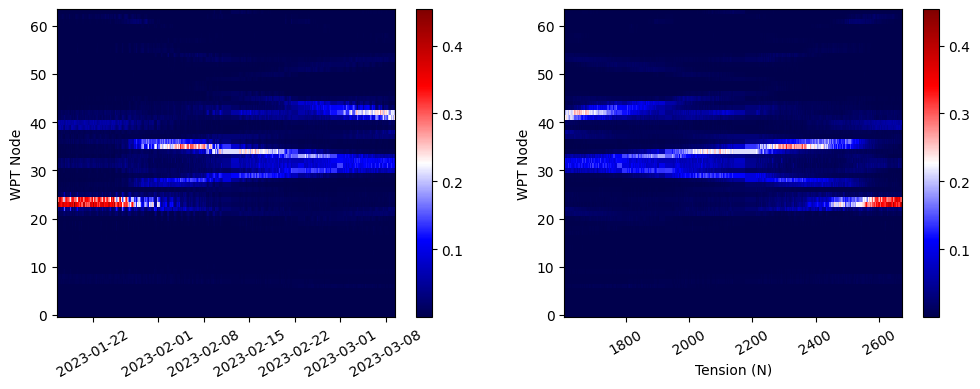

In [32]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.pcolormesh(dataset_per_cable["c1"].index, np.arange(test.shape[1]), test.T, cmap="seismic")
plt.xticks(rotation=30);
plt.ylabel("WPT Node");
plt.colorbar();

plt.subplot(1,2,2)
plt.pcolormesh(dataset_per_cable["c1"].tension, np.arange(test.shape[1]), test.T, cmap="seismic")
plt.xticks(rotation=30);
plt.ylabel("WPT Node");
plt.xlabel("Tension (N)");
plt.colorbar();

# Example: hyperparameters tuning

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [134]:
pipeline = Pipeline(
    [
        ("feature", WPTFeatureExtractor(normalize=True)),
        ("reduction", PCAModel(cumulative=0.99))
    ]
)

params_grid = {
    "feature__family": ["haar", "db4", "db16"],
    "feature__level": [3,4,5],
}

x_train = x[0:]
y_train = y[0:].flatten()

In [160]:
x_train.shape

(4404,)

In [35]:
# del dataset_per_cable

In [135]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('feature', WPTFeatureExtractor(normalize=True)),
                ('reduction', PCAModel(cumulative=0.99))])

In [136]:
pipeline.predict(x_train)

1

<StemContainer object of 3 artists>

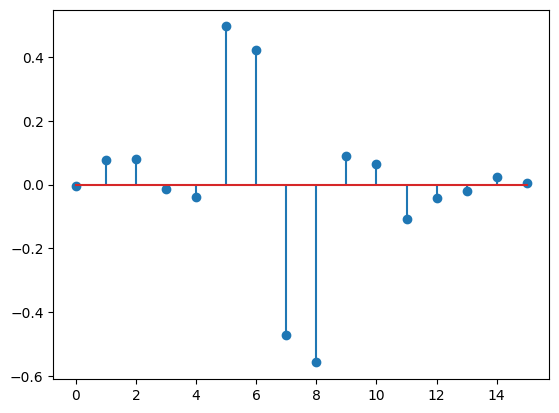

In [159]:
plt.stem(pipeline["reduction"].model.components_[0])

In [140]:
xx = x_train[[0]]
f = pipeline["feature"].transform(xx).flatten()

In [156]:
np.dot(f - pipeline["reduction"].model.mean_, pipeline["reduction"].model.components_[0])

0.2817410452390784

In [128]:
xx.shape

(1, 1)

In [67]:
search = GridSearchCV(pipeline, params_grid, n_jobs=2, scoring="explained_variance", cv=5, verbose=1)

In [68]:
search.fit(x_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/opt/conda/lib/python3.8/site-packages/sklearn/utils/_available_if.py", line 32, in __get__
    if not self.check(obj):
  File "/opt/conda/lib/python3.8/site-packages/sklearn

KeyboardInterrupt: 